In [13]:


from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)



/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35993 instead
  warnings.warn(


In [14]:
print(client)

<Client: 'tcp://127.0.0.1:37407' processes=5 threads=20, memory=31.35 GiB>


In [15]:
# loadings and defaults
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage

import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker

%config InlineBackend.figure_format='png'



In [16]:
# convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")

# arr_start_ps=(2234.541e3,-1021.968e3)
# arr_start = ps_to_ll.transform(arr_start_ps[0],arr_start_ps[1])
# print(arr_start_ps)
# arr_end = ll_to_ps.transform(arr_start[0]+0.15,arr_start[1])
# print(arr_end)



In [17]:
# load tisom history file

ds = xr.open_dataset('../data/raw/tisom_his_0021.nc')

ds = ds.drop_vars(['temp','salt','rho','w','omega','dye_01','AKv','AKs','AKt','shflux','ssflux','sustr','svstr','Tb','Sb','m','ubar','vbar'])

In [18]:
ds['zeta'] = ds.zeta.mean(dim='ocean_time')
ds['u'] = ds.u.mean(dim='ocean_time')
ds['v'] = ds.v.mean(dim='ocean_time')

In [60]:
x_rho,y_rho = ll_to_ps.transform(ds.lat_rho,ds.lon_rho)

ds['x_rho']=(('eta_rho','xi_rho'),x_rho)
ds['y_rho']=(('eta_rho','xi_rho'),y_rho)

In [19]:
# ROMS grid loader functions


from xgcm import Grid

def makeROMSGridObject(ds,rename=True):
    if rename==True:
        ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])
    print('make vertical coords')
    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    print('interpolate to depth levels')
     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    print('make pm/pn')
    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('making dx')
    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi
    print('making dy')
    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi
    print('making dz')
    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy
    print('making metrics')
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    print('making grid object')
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds, grid

# def makeROMSGridObject(gridIn):
#     gridOut = Grid(gridIn, 
#     coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
#     'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
#     'Z':{'center':'s_rho', 'outer':'s_w'}},
#     metrics={
#         ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
#         ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
#         ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
#         ('X', 'Y'): ['dA'] # Areas
#     },
#     periodic=False)
#     return gridOut

In [34]:
ds.nbytes/1e9
ds

<xarray.Dataset>
Dimensions:        (tracer: 3, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 260,
                    xi_rho: 381, xi_u: 380, eta_v: 259, ocean_time: 365)
Coordinates: (12/13)
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    lon_rho        (eta_rho, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
    lat_rho        (eta_rho, xi_rho) float64 -67.59 -67.59 ... -60.02 -60.02
    lon_u          (eta_rho, xi_u) float64 ...
    lat_u          (eta_rho, xi_u) float64 ...
    ...             ...
    lat_v          (eta_v, xi_rho) float64 ...
    lon_psi        (eta_v, xi_u) float64 ...
    lat_psi        (eta_v, xi_u) float64 ...
  * ocean_time     (ocean_time) object 0020-12-29 00:00:00 ... 0001-01-01 00:...
    z_w            (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.03262 -0.03262
    z_rho          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.8803 -0.8803
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/94)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         object ...
    nHIS           int32 ...
    ...             ...
    dz_w_u         (s_w, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 0.8797 0.8803
    dz_v           (s_rho, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_v         (s_w, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 0.8803 0.8803
    dA             (eta_rho, xi_rho) float64 8.218e+06 8.218e+06 ... 1.5e+07
    u_rho          (s_rho, eta_rho, xi_rho) float32 0.0 0.0 ... 0.05702 0.02619
    v_rho          (s_rho, eta_rho, xi_rho) float32 0.0 0.0 ... 0.007382
Attributes: (12/27)
    file:              tisom_his_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Totten Ice Shelf/Ocean Application
    rst_file:          tisom_rst.nc
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            016x018
    history:           ROMS/TOMS, Version 3.7, Saturday - August 8, 2020 - 10...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       TOTTEN_SGFW, ADD_FSOBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BT...

In [21]:
ds, grid = makeROMSGridObject(ds)

make vertical coords
interpolate to depth levels
make pm/pn
making dx
making dy
making dz
making metrics
making grid object


In [24]:
ds['u_rho'] = grid.interp(ds['u'],'X',boundary='fill')
ds['v_rho'] = grid.interp(ds['v'],'Y',boundary='fill')

/tmp/ipykernel_613/3166147479.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds.lon_rho,ds.lat_rho,ds.u_rho.isel(s_rho=-1))


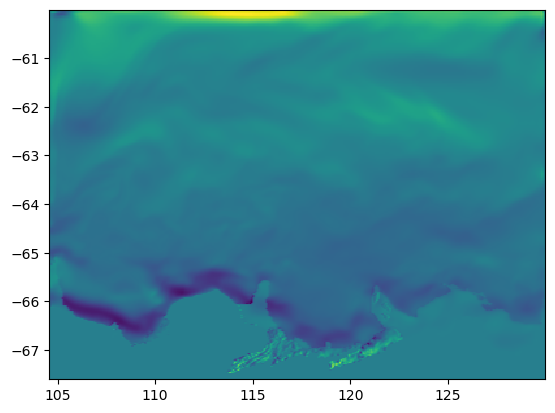

In [35]:
plt.pcolormesh(ds.lon_rho,ds.lat_rho,ds.u_rho.isel(s_rho=-1))

In [46]:
ds.u_rho.shape

(31, 260, 381)

<Figure size 640x480 with 0 Axes>

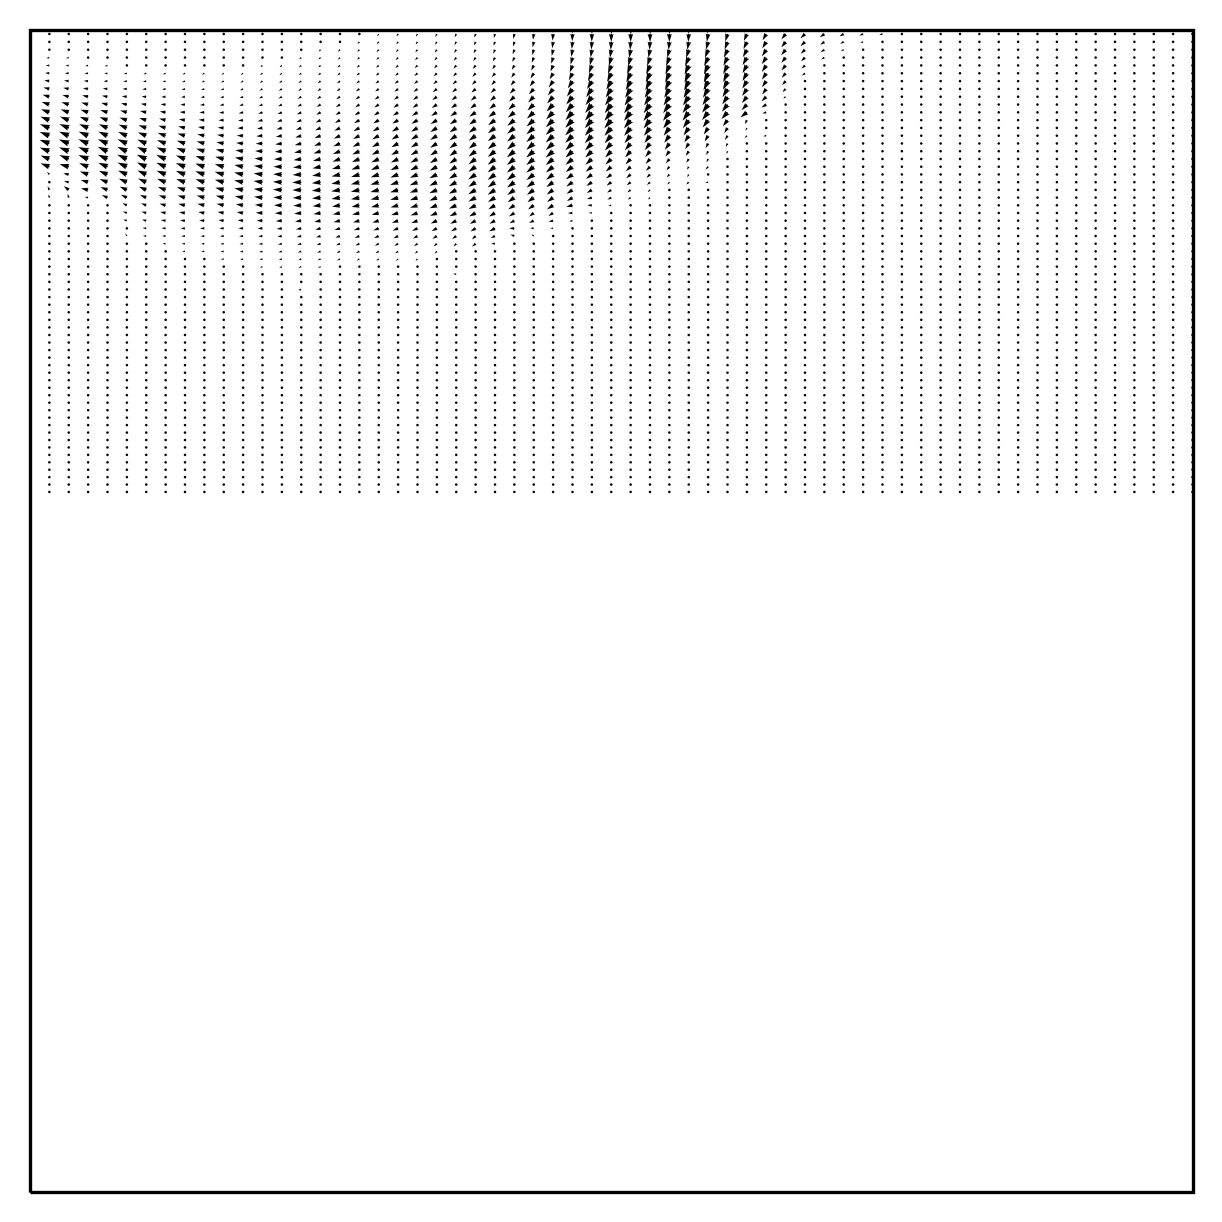

In [53]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,9],dpi=300)
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([108,112,-70,-66])

ax.quiver(ds.lon_rho.values, ds.lat_rho.values, ds.u_rho.isel(s_rho=-1).values.squeeze(), ds.v_rho.isel(s_rho=-1).values.squeeze())

<Figure size 640x480 with 0 Axes>

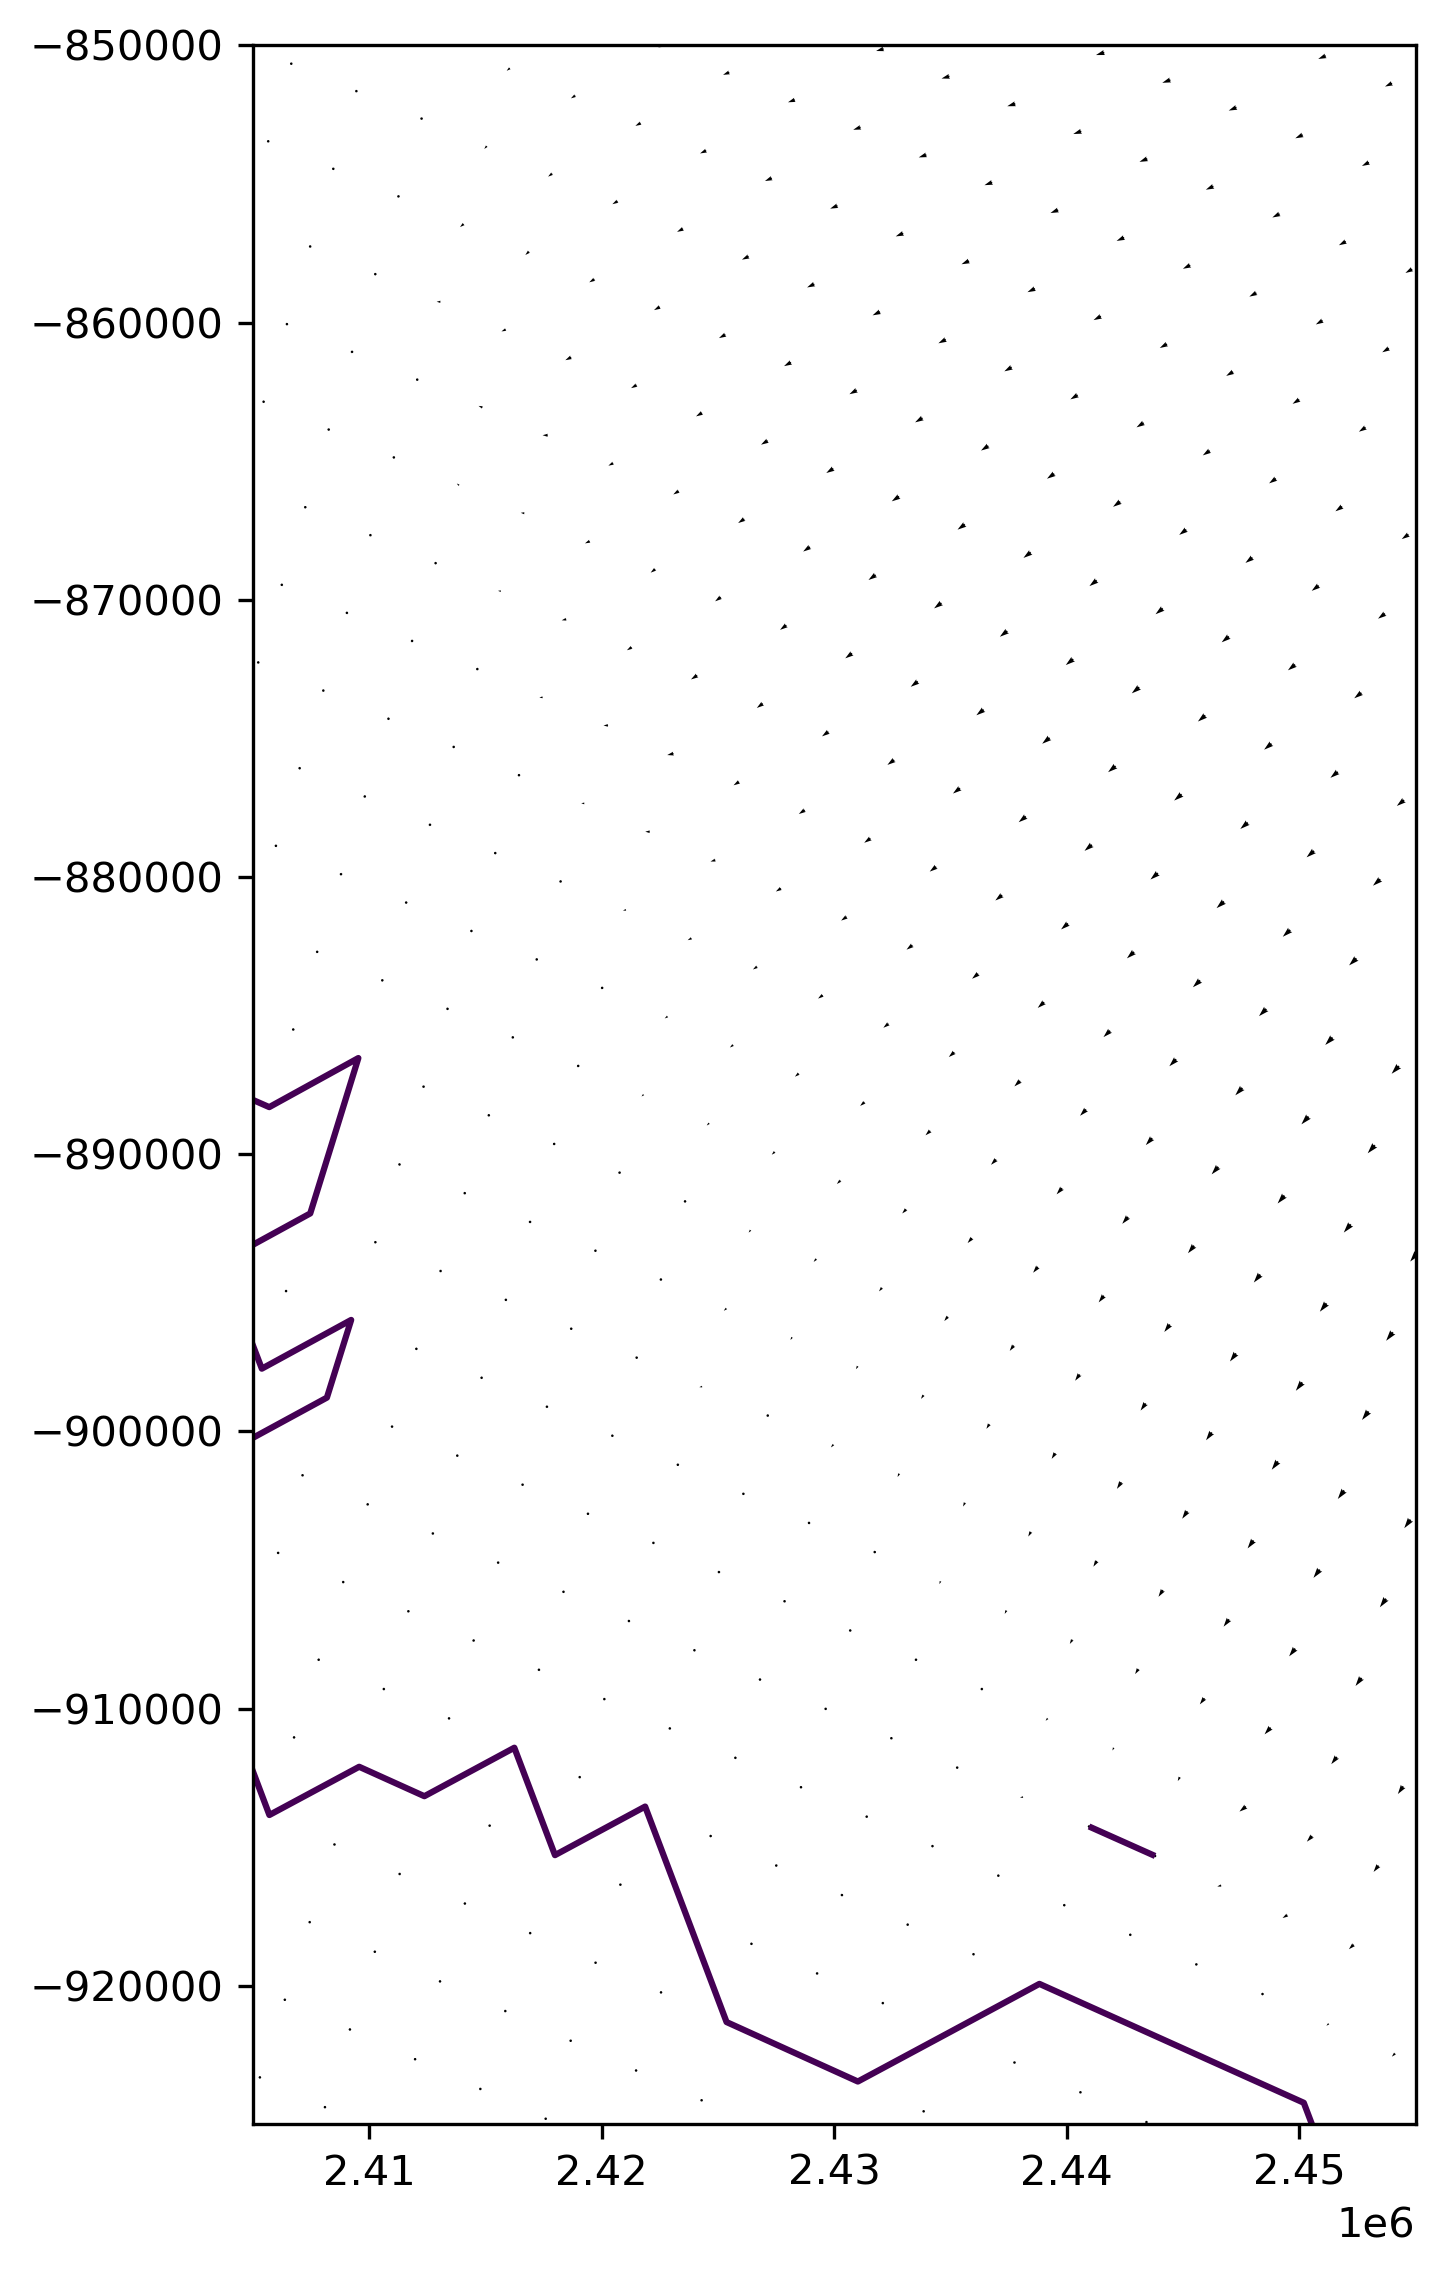

In [71]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,9],dpi=300)
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
ax.axis([2.405e6,2.455e6,-.925e6,-.85e6])

ax.quiver(ds.x_rho.values, ds.y_rho.values, ds.u_rho.isel(s_rho=-1).values.squeeze(), ds.v_rho.isel(s_rho=-1).values.squeeze())
ax.contour(ds.x_rho, ds.y_rho, ds.mask_rho,levels=np.array([0,1]))


ValueError: The rows of 'x' must be equal

<Figure size 640x480 with 0 Axes>

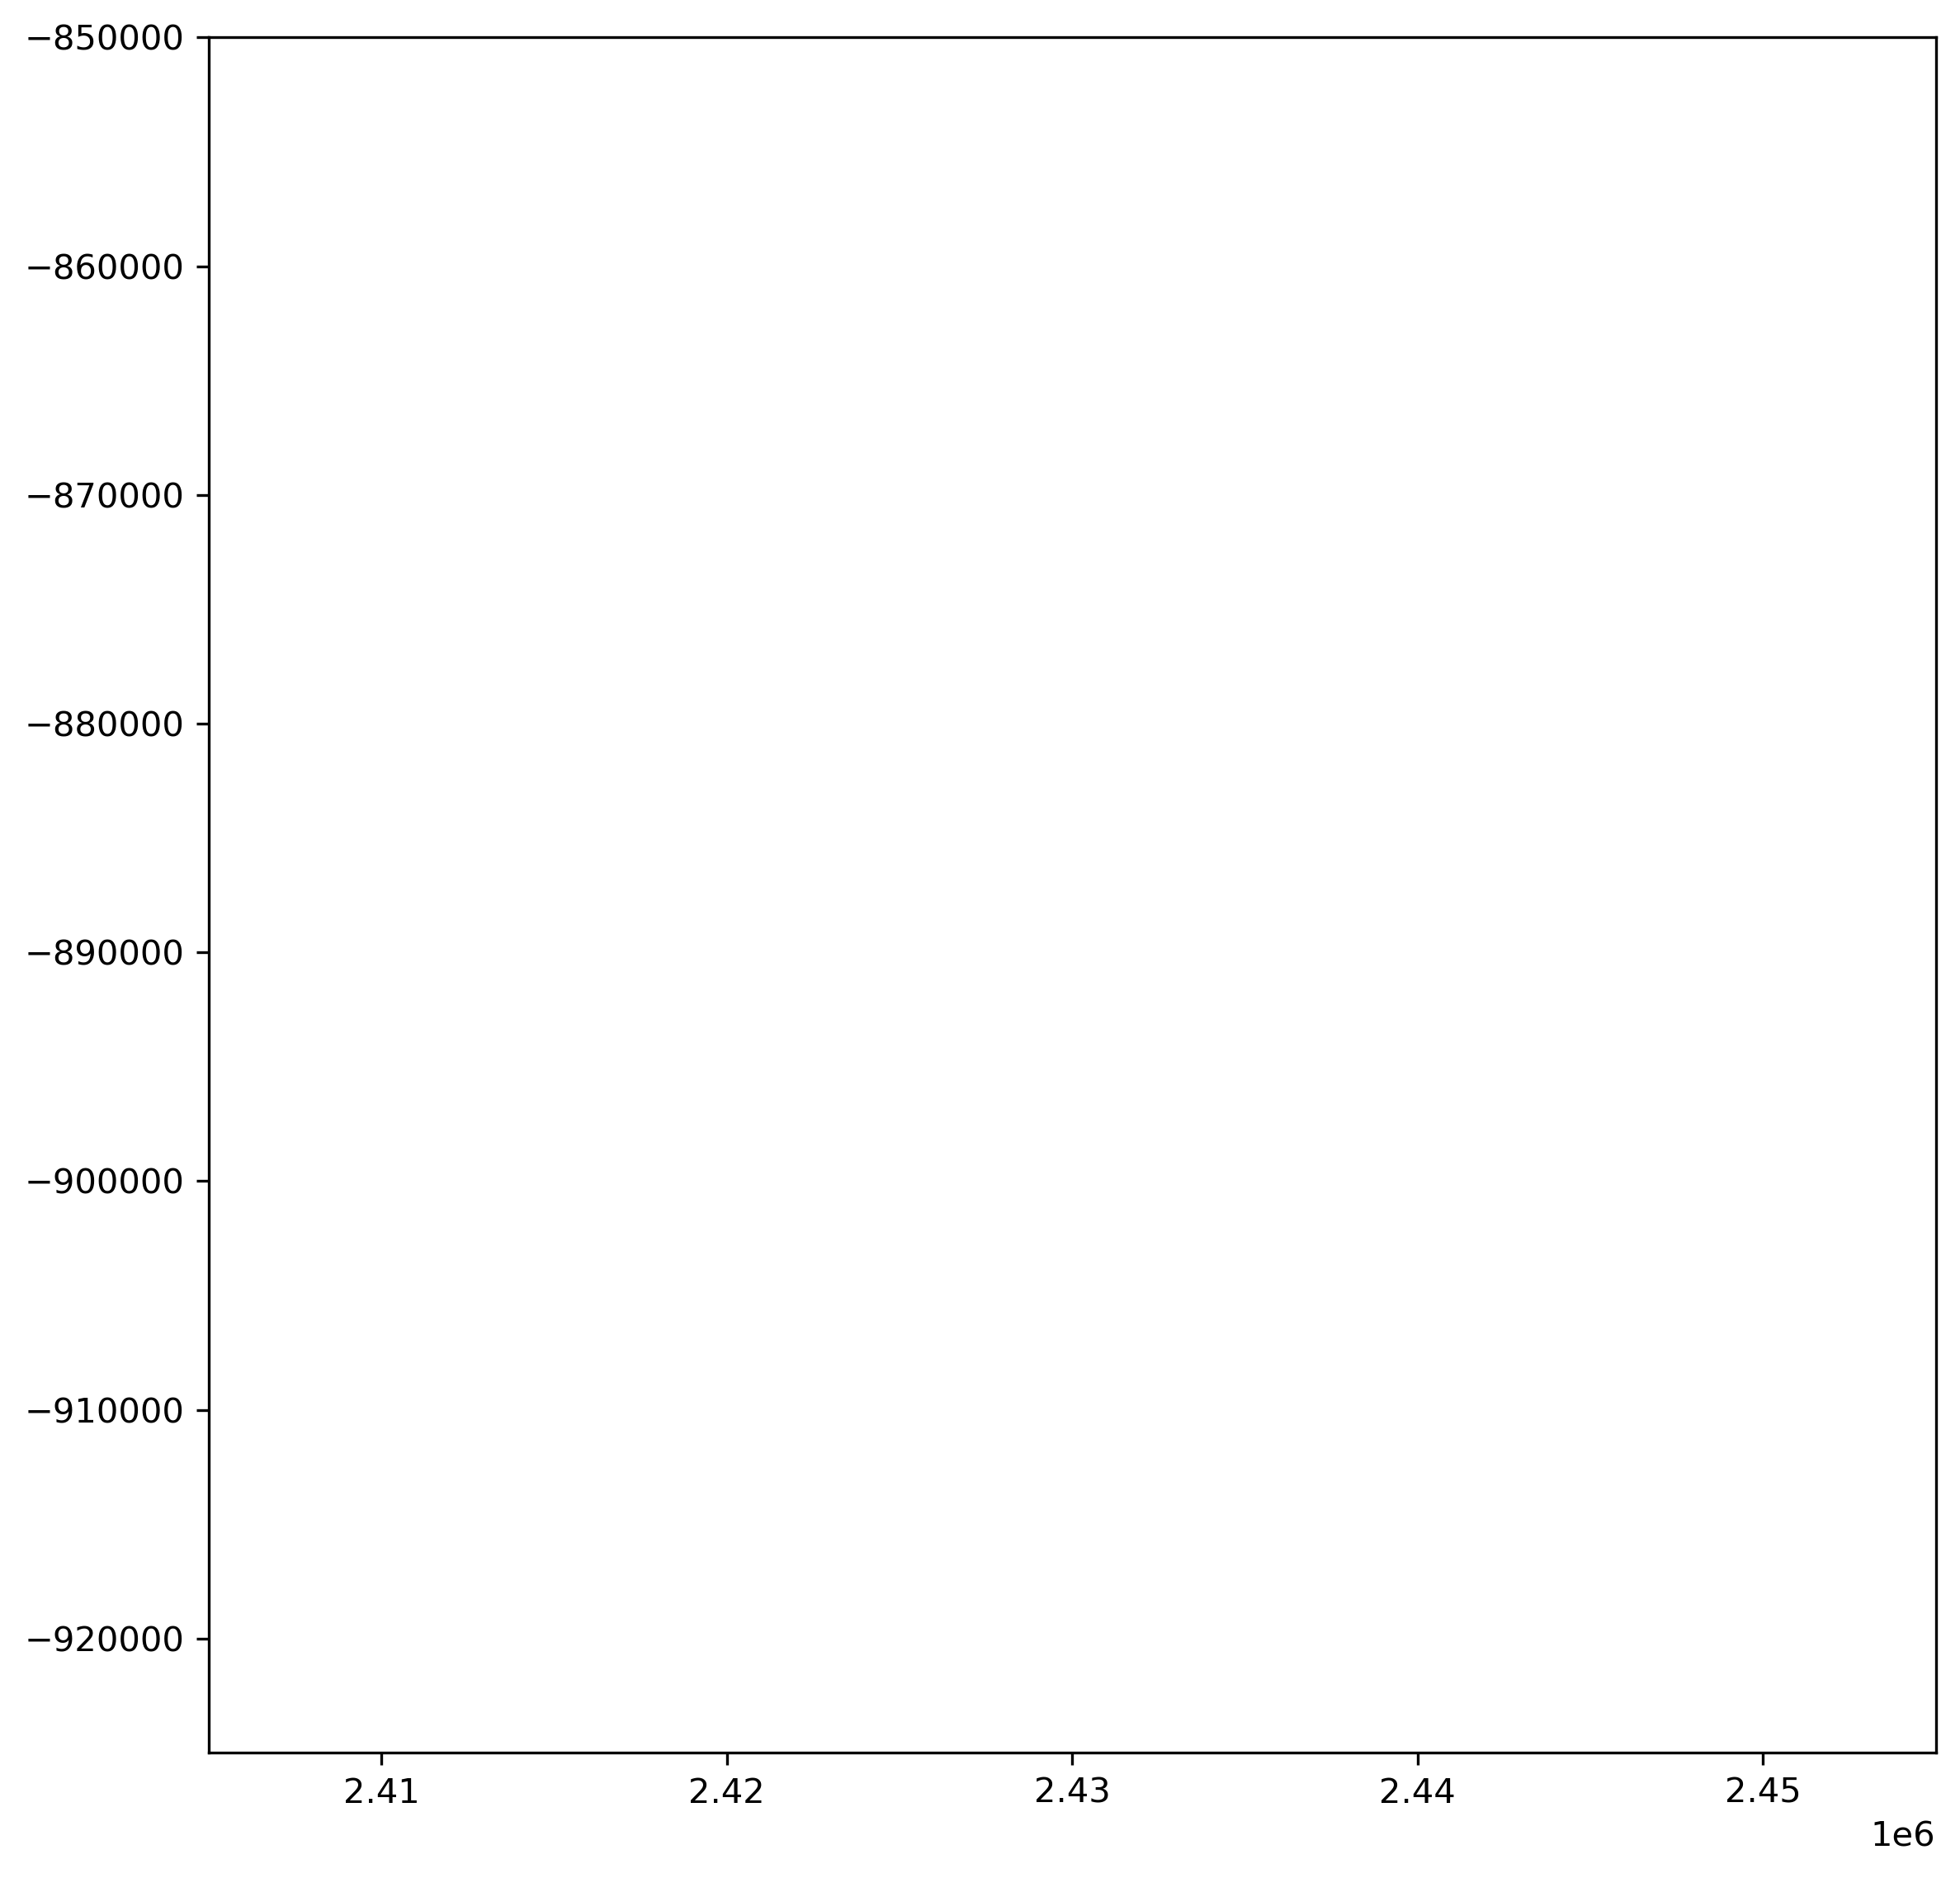

In [70]:


# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,9],dpi=300)
ax = None


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
ax.axis([2.405e6,2.455e6,-.925e6,-.85e6])
# feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

# im = aviso_s.sla.plot(ax=ax,x='longitude',y='latitude',add_colorbar=False,**pcol_kwargs) 

# # aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
# str_kwargs = {"color":aviso_s.umag.values,
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#               "cmap":"Greys",
#              "transform":ccrs.PlateCarree()}
str_kwargs = {"color":'0.6',
              "linewidth":.5,
              "arrowsize":.5,
              "density":3,
             "transform":ccrs.PlateCarree()}
st = ax.streamplot(ds.x_rho.values, ds.y_rho.values, ds.u_rho.isel(s_rho=-1).values.squeeze(), ds.v_rho.isel(s_rho=-1).values.squeeze(),**str_kwargs)
ax.contour(ds.x_rho, ds.y_rho, ds.mask_rho,levels=np.array([0,1]))


gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
# ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')
# ax[0].text(0.5, 1.05, 'Experiment layout',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
# ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')

# # add colorbar
# cax = inset_axes(ax,
#                  width="7%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05,0, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('SLA (m)')


Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

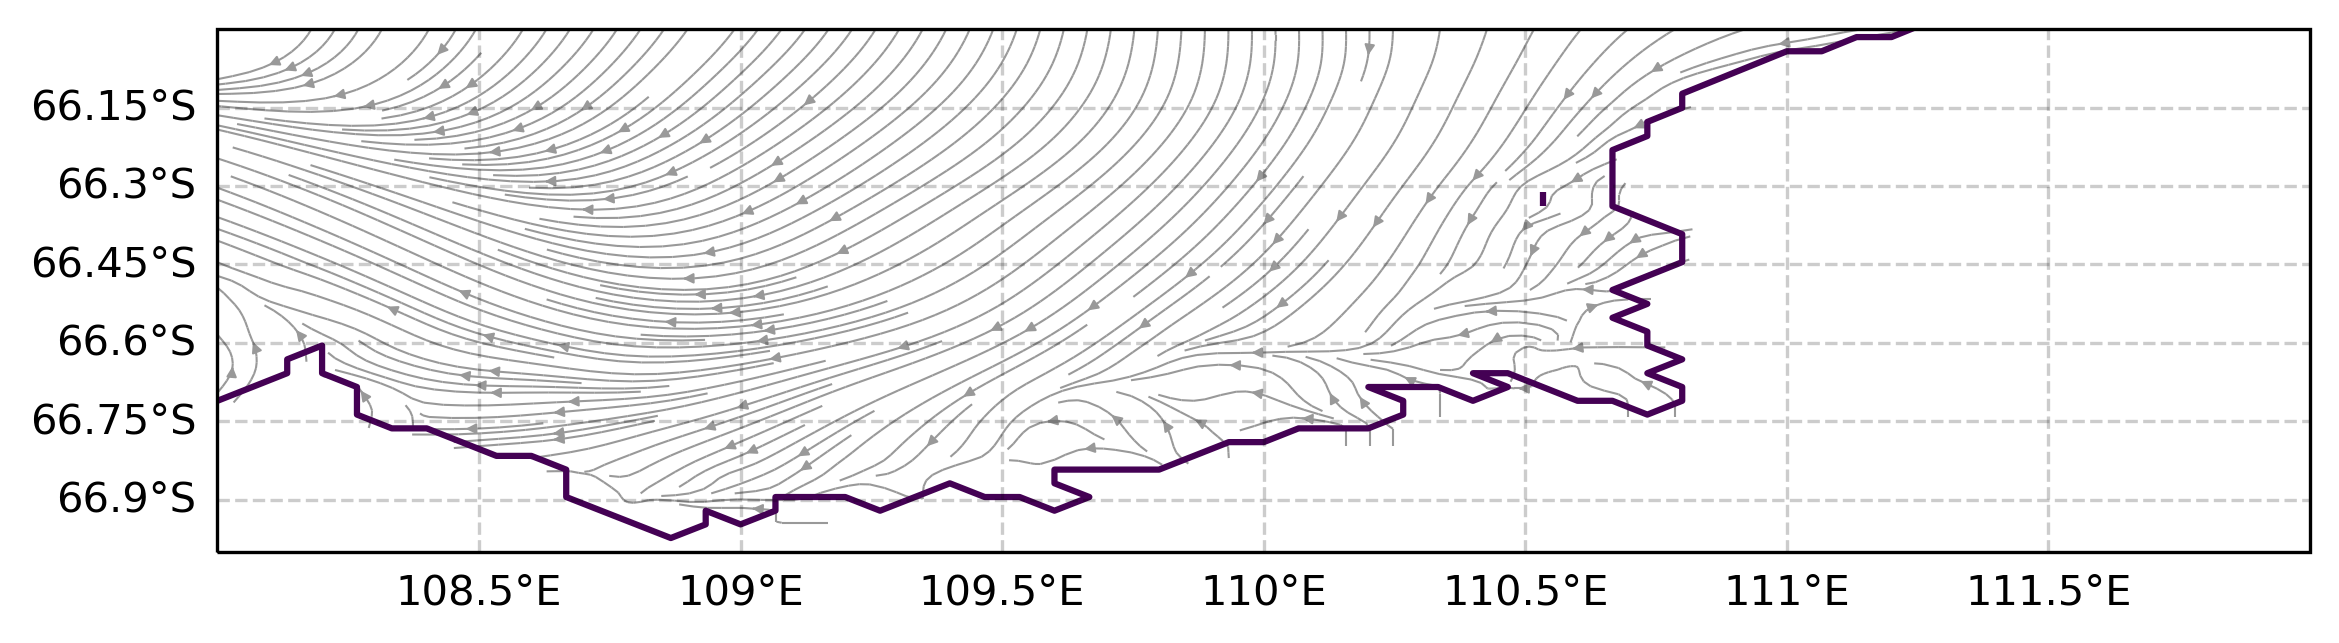

In [54]:
# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,9],dpi=300)
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([108,112,-67,-66])
# feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

# im = aviso_s.sla.plot(ax=ax,x='longitude',y='latitude',add_colorbar=False,**pcol_kwargs) 

# # aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
# str_kwargs = {"color":aviso_s.umag.values,
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#               "cmap":"Greys",
#              "transform":ccrs.PlateCarree()}
str_kwargs = {"color":'0.6',
              "linewidth":.5,
              "arrowsize":.5,
              "density":3,
             "transform":ccrs.PlateCarree()}
st = ax.streamplot(ds.lon_rho.values, ds.lat_rho.values, ds.u_rho.isel(s_rho=-1).values.squeeze(), ds.v_rho.isel(s_rho=-1).values.squeeze(),**str_kwargs)
ax.contour(ds.lon_rho, ds.lat_rho, ds.mask_rho,levels=np.array([0,1]))


gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
# ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')
# ax[0].text(0.5, 1.05, 'Experiment layout',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
# ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')

# # add colorbar
# cax = inset_axes(ax,
#                  width="7%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05,0, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('SLA (m)')


Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

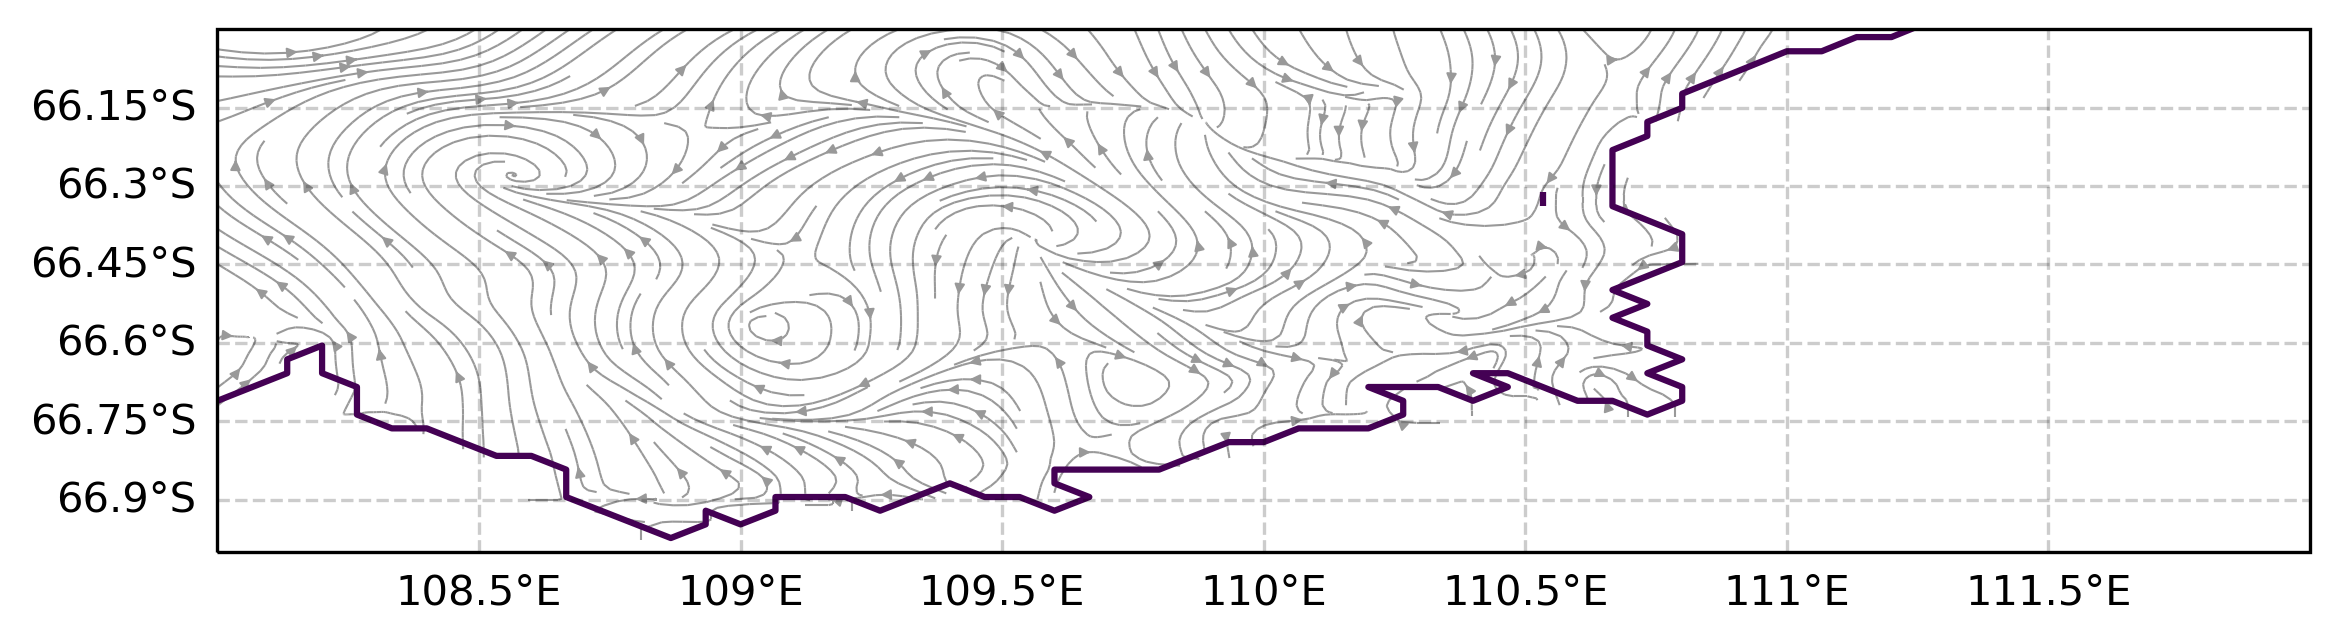

In [72]:
# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[9,9],dpi=300)
ax = None


ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([108,112,-67,-66])
# feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

# im = aviso_s.sla.plot(ax=ax,x='longitude',y='latitude',add_colorbar=False,**pcol_kwargs) 

# # aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
# str_kwargs = {"color":aviso_s.umag.values,
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#               "cmap":"Greys",
#              "transform":ccrs.PlateCarree()}
str_kwargs = {"color":'0.6',
              "linewidth":.5,
              "arrowsize":.5,
              "density":3,
             "transform":ccrs.PlateCarree()}
st = ax.streamplot(ds.lon_rho.values, ds.lat_rho.values, ds.u_rho.isel(s_rho=0).values.squeeze(), ds.v_rho.isel(s_rho=0).values.squeeze(),**str_kwargs)
ax.contour(ds.lon_rho, ds.lat_rho, ds.mask_rho,levels=np.array([0,1]))


gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
# ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')
# ax[0].text(0.5, 1.05, 'Experiment layout',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
# ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
# ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')

# # add colorbar
# cax = inset_axes(ax,
#                  width="7%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05,0, 1, 1),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# cbar = fig.colorbar(im, cax=cax)
# cbar.ax.set_ylabel('SLA (m)')


In [22]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
# re-make the original fig from matlab
cmap = cmocean.cm.curl
newcmap = cmocean.tools.crop(cmap, vmin=-10,vmax=80,pivot=0)

gs0 = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[2,1])
gs00 = gs0[0].subgridspec(1, 2,wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(1, 1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,12.5])
ax = None

# add plots

ax1 = fig.add_subplot(gs00[0,0])
moa.plot(ax=ax1,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
Gourmelen.plot(ax=ax1,vmin=-10,vmax=80,cmap=newcmap,add_colorbar=False)
ax1.scatter(apres_x,apres_y,s=95,c=apres_m,cmap=newcmap,vmin=-10,vmax=80,edgecolors='k')
ax1.set_facecolor('xkcd:dark navy')
ax1.set_ylabel('Northings (km)')
ax1.set_xlabel('Eastings (km)')
ax1.grid()
ax1.text(0.01, 0.99, 'a  Satellite + ApRES', transform=ax1.transAxes,fontsize=14, fontweight='bold', va='top')
ax1.text(0.99, 0.99, '12$\pm$1.4 m/yr', transform=ax1.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax1.set_ylim([-1.170e6,-.9750e6])
ax1.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax1.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax1.yaxis.set_major_formatter(ticks_y)
# axis decorations
ax1.text(2240e3,-1147e3,'Eastern\nchannel',fontsize=14, multialignment='center')
ax1.text(2310e3,-1070e3,'Law\nDome',fontsize=14, multialignment='left')
ax1.text(2295e3,-1143e3,'Calving front',fontsize=14)
ax1.text(2245e3,-1004e3,'Grounding\nline',fontsize=14, multialignment='left')
ax1.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax1.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)
ax1.set_title('')

#

ax2 = fig.add_subplot(gs00[0,1])
moa.plot(ax=ax2,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
im = plt.pcolormesh(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Melt'],vmin=-10,vmax=80,cmap=newcmap)
ax2.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Zice']*-1,levels=np.array([0,1]),colors='C1')
ax2.scatter(apres_x,apres_y,s=95,c=apres_m,cmap=newcmap,vmin=-10,vmax=80,edgecolors='k')
ax2.set_facecolor('xkcd:dark navy')
ax2.set_ylabel('')
ax2.set_xlabel('Eastings (km)')
ax2.grid()
ax2.text(0.01, 0.99, 'b  ROMS', transform=ax2.transAxes,fontsize=14, fontweight='bold', va='top')
ax2.text(0.99, 0.99, '8.3 m/yr', transform=ax2.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax2.set_ylim([-1.170e6,-.9750e6])
ax2.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax2.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_yticklabels([])
ax2.set_title('')
cax = inset_axes(ax2,
                width="5%",  # width = 10% of parent_bbox width
                height="95%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.06,0, 1, 1),
                bbox_transform=ax2.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title('melt\n(m/yr)', multialignment='left')

#

ax3 = fig.add_subplot(gs01[0,0])
moa.plot(ax=ax3,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
im = plt.pcolormesh(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['PercentDiff'],vmin=-10,vmax=10,cmap='cmo.balance')
ax3.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['PercentDiff'],levels=[0],colors='k')
ax3.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Zice']*-1,levels=np.array([0,1]),colors='C1')
ax3.set_facecolor('xkcd:dark navy')
ax3.set_ylabel('')
ax3.set_xlabel('Eastings (km)')
ax3.grid()
ax3.text(0.01, 0.99, 'c  ROMS %$\Delta$ with SGFW', transform=ax3.transAxes,fontsize=14, fontweight='bold', va='top')
ax3.text(0.99, 0.99, 'total change: 3%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
ax3.text(0.99, 0.96, 'mean inc.: 4.9%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
ax3.text(0.99, 0.93, 'mean dec.: -1.6%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax3.set_ylim([-1.170e6,-.9750e6])
ax3.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax3.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax3.yaxis.set_major_formatter(ticks_y)
# ax3.set_yticklabels([])
ax3.set_title('')
cax = inset_axes(ax3,
                width="5%",  # width = 10% of parent_bbox width
                height="95%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.08,.00, 1, 1),
                bbox_transform=ax3.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title('% diff\nto No Flow', multialignment='left')


# plt.savefig('../outputs/figure_bathy_draft.png',dpi=300)


In [ ]:
# and now do the same, but with the symlognorm colorbar
cmap = cmocean.cm.curl
newcmap = cmocean.tools.crop(cmap, vmin=-10,vmax=80,pivot=0)

gs0 = fig.add_gridspec(nrows=1,ncols=2,width_ratios=[2,1])
gs00 = gs0[0].subgridspec(1, 2,wspace=0.05, hspace=0.05)
gs01 = gs0[1].subgridspec(1, 1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,12.5])
ax = None

# add plots

ax1 = fig.add_subplot(gs00[0,0])
moa.plot(ax=ax1,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
Gourmelen.plot(ax=ax1,vmin=-10,vmax=80,cmap=newcmap,add_colorbar=False)
ax1.scatter(apres_x,apres_y,s=95,c=apres_m,cmap=newcmap,vmin=-10,vmax=80,edgecolors='k')
ax1.set_facecolor('xkcd:dark navy')
ax1.set_ylabel('Northings (km)')
ax1.set_xlabel('Eastings (km)')
ax1.grid()
ax1.text(0.01, 0.99, 'a  Satellite', transform=ax1.transAxes,fontsize=14, fontweight='bold', va='top')
ax1.text(0.99, 0.99, '12$\pm$1.4 m/yr', transform=ax1.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax1.set_ylim([-1.170e6,-.9750e6])
ax1.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax1.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax1.yaxis.set_major_formatter(ticks_y)
# axis decorations
ax1.text(2240e3,-1147e3,'Eastern\nchannel',fontsize=14, multialignment='center')
ax1.text(2310e3,-1070e3,'Law\nDome',fontsize=14, multialignment='left')
ax1.text(2295e3,-1143e3,'Calving front',fontsize=14)
ax1.text(2245e3,-1004e3,'Grounding\nline',fontsize=14, multialignment='left')
ax1.annotate('', xy = (arr_start_ps[0],arr_start_ps[1]),  xycoords = 'data', \
    xytext = (arr_end[0],arr_end[1]), textcoords = 'data', fontsize = 7, \
    color = '#303030', arrowprops=dict(edgecolor='black', shrinkA = 0, shrinkB = 0,arrowstyle='<-',lw=3))
ax1.text(arr_end[0],arr_end[1],'N',fontweight='bold',fontsize=14)
ax1.set_title('')

#

ax2 = fig.add_subplot(gs00[0,1])
moa.plot(ax=ax2,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
im = plt.pcolormesh(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Melt'],vmin=-10,vmax=80,cmap=newcmap)
ax2.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Zice']*-1,levels=np.array([0,1]),colors='C1')
ax2.scatter(apres_x,apres_y,s=95,c=apres_m,cmap=newcmap,vmin=-10,vmax=80,edgecolors='k')
ax2.set_facecolor('xkcd:dark navy')
ax2.set_ylabel('')
ax2.set_xlabel('Eastings (km)')
ax2.grid()
ax2.text(0.01, 0.99, 'b  ROMS', transform=ax2.transAxes,fontsize=14, fontweight='bold', va='top')
ax2.text(0.99, 0.99, '8.3 m/yr', transform=ax2.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax2.set_ylim([-1.170e6,-.9750e6])
ax2.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax2.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax2.yaxis.set_major_formatter(ticks_y)
ax2.set_yticklabels([])
ax2.set_title('')
cax = inset_axes(ax2,
                width="5%",  # width = 10% of parent_bbox width
                height="95%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.06,0, 1, 1),
                bbox_transform=ax2.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cax.set_title('melt\n(m/yr)', multialignment='left')

#

ax3 = fig.add_subplot(gs01[0,0])
moa.plot(ax=ax3,cmap='Greys',vmin=12000 ,vmax=20000,add_colorbar=False)
im = plt.pcolormesh(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['PercentDiff'],
                    norm = colors.SymLogNorm(linthresh = 1,
                                                linscale = .3,
                                                vmin =-40.0, 
                                                vmax = 40.0),
                    cmap='RdBu_r')
ax3.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['PercentDiff'],levels=[0],colors='k')
ax3.contour(roms['Coord_x']*1000,roms['Coord_y']*1000,roms['Zice']*-1,levels=np.array([0,1]),colors='C1')
ax3.set_facecolor('xkcd:dark navy')
ax3.set_ylabel('')
ax3.set_xlabel('Eastings (km)')
ax3.grid()
ax3.text(0.01, 0.99, 'c  ROMS %$\Delta$ with SGFW', transform=ax3.transAxes,fontsize=14, fontweight='bold', va='top')
ax3.text(0.99, 0.99, 'total change: 3%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
ax3.text(0.99, 0.96, 'mean inc.: 4.9%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
ax3.text(0.99, 0.93, 'mean dec.: -1.6%', transform=ax3.transAxes,fontsize=14, va='top',ha='right')
plt.axis('scaled')
ax3.set_ylim([-1.170e6,-.9750e6])
ax3.set_xlim([2.220e6,2.340e6])
plt.xticks(rotation=45)
scale_ticks = 1e3
ticks_x = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax3.xaxis.set_major_formatter(ticks_x)
ticks_y = mticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_ticks))
ax3.yaxis.set_major_formatter(ticks_y)
# ax3.set_yticklabels([])
ax3.set_title('')
cax = inset_axes(ax3,
                width="5%",  # width = 10% of parent_bbox width
                height="95%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(1.08,.00, 1, 1),
                bbox_transform=ax3.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax,ticks=[-40,-20,-10,-5,-2.5,-1,0,1,2.5,5,10,20,40]) 
cax.set_title('% diff\nto No Flow', multialignment='left')
cax.set_yticklabels([-40,-20,-10,-5,-2.5,-1,0,1,2.5,5,10,20,40])

# plt.savefig('../outputs/figure_bathy_draft.png',dpi=300)


In [ ]:
STOP

In [ ]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,((norm.m*365*60*60*24).mean(dim='ocean_time')-(noflow.m*365*60*60*24).mean(dim='ocean_time'))/(noflow.m*365*60*60*24).mean(dim='ocean_time')*100,vmin=-10,vmax=10,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


In [ ]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=-1).mean(dim='ocean_time')-noflow.temp.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.05,vmax=.05,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.20e3,-.987e3])
plt.colorbar(im)


In [ ]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=0).mean(dim='ocean_time')-noflow.temp.isel(s_rho=0).mean(dim='ocean_time'),vmin=-.05,vmax=.05,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.20e3,-.987e3])
plt.colorbar(im)


In [ ]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.salt.isel(s_rho=-1).mean(dim='ocean_time')-noflow.salt.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


In [ ]:


im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm_uv.vmag.isel(s_rho=-1).mean(dim='ocean_time')-noflow_uv.vmag.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.01,vmax=.01,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm_uv.vmag.isel(s_rho=25).mean(dim='ocean_time')-noflow_uv.vmag.isel(s_rho=25).mean(dim='ocean_time'),vmin=-.01,vmax=.01,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=25).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=25).mean(dim='ocean_time'),units='xy',pivot='mid',scale=1)
plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm_uv.vmag.isel(s_rho=15).mean(dim='ocean_time')-noflow_uv.vmag.isel(s_rho=15).mean(dim='ocean_time'),vmin=-.01,vmax=.01,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=15).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=15).mean(dim='ocean_time'),units='xy',pivot='mid',scale=1)
plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm_uv.vmag.isel(s_rho=0).mean(dim='ocean_time')-noflow_uv.vmag.isel(s_rho=0).mean(dim='ocean_time'),vmin=-.01,vmax=.01,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=0).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=0).mean(dim='ocean_time'),units='xy',pivot='mid',scale=1)
plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=25).mean(dim='ocean_time')-noflow.temp.isel(s_rho=25).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=25).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=25).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1)
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=25).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=25).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r')

plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=15).mean(dim='ocean_time')-noflow.temp.isel(s_rho=15).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=15).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=15).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1)
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=15).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=15).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r')

plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

fig = plt.figure(figsize=(20,20))
im=plt.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=0).mean(dim='ocean_time')-noflow.temp.isel(s_rho=0).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=0).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=0).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1)
qu = plt.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=0).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=0).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r')

plt.xlim([113.5,117.5])
plt.ylim([-67.8,-66.25])
plt.colorbar(im)


In [ ]:

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=25).mean(dim='ocean_time')-noflow.temp.isel(s_rho=25).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=25).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=25).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,minshaft=3)
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=25).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=25).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r',minshaft=3)
ax.set_xticklabels([])
ax.set_xlim([113.5,117.25])
ax.set_ylim([-67.6,-66.6])
ax.text(0.02, 0.98, 'a    sub-surface layer', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
im=ax.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=15).mean(dim='ocean_time')-noflow.temp.isel(s_rho=15).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=15).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=15).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,minshaft=3)
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=15).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=15).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r',minshaft=3)
ax.set_xticklabels([])
ax.set_xlim([113.5,117.25])
ax.set_ylim([-67.6,-66.6])
ax.text(0.02, 0.98, 'b    intermediate layer', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')
ax.text(-.05, .5, 'Latitude ($^\circ$N)',fontsize=16, va='center', ha='center', rotation='vertical', transform=ax.transAxes)

ax=fig.add_subplot(gs[2,0])
im=ax.pcolormesh(gridFile.lon_rho,gridFile.lat_rho,norm.temp.isel(s_rho=0).mean(dim='ocean_time')-noflow.temp.isel(s_rho=0).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,norm_uv.u_rho.isel(s_rho=0).mean(dim='ocean_time'),norm_uv.v_rho.isel(s_rho=0).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,minshaft=3)
qu = ax.quiver(gridFile.lon_rho,gridFile.lat_rho,noflow_uv.u_rho.isel(s_rho=0).mean(dim='ocean_time'),noflow_uv.v_rho.isel(s_rho=0).mean(dim='ocean_time'),units='xy',pivot='tail',scale=1,color='r',minshaft=3)
qu = ax.quiver(113.8,-66.7,.1,0,units='xy',pivot='tail',scale=1,color='k',minshaft=3)
ax.text(113.58,-66.7,'0.1 m/s',va='center',fontweight='bold',fontsize=14)
ax.set_xlim([113.5,117.25])
ax.set_ylim([-67.6,-66.6])
ax.text(0.5, -0.1, 'Longitude ($^\circ$E)',fontsize=16, va='top', ha='center', transform=ax.transAxes)
ax.text(0.02, 0.98, 'c    bottom layer', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')
cax = inset_axes(ax,
                 width="1%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.055,.41, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
cax.set_title('$\Delta$ temp. ($^\circ$C)',fontweight='bold')
